In [65]:
# !pip install pandas==3.0.0 pytorch-ignite
!pip install pandas pytorch-ignite piq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 11.2 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount("/content/drive")
# /content/drive/MyDrive/Colab_Notebooks/NeuroInfo/data/misc


Mounted at /content/drive


In [3]:
PATH = "/content/drive/MyDrive/Colab_Notebooks/NeuroInfo"
import sys
sys.path.insert(0, PATH)
print(sys.path)

['/content/drive/MyDrive/Colab_Notebooks/NeuroInfo', '/content', '/env/python', '/usr/lib/python312.zip', '/usr/lib/python3.12', '/usr/lib/python3.12/lib-dynload', '', '/usr/local/lib/python3.12/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.12/dist-packages/IPython/extensions', '/root/.ipython']


In [4]:
import os
import re
import sys
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Model

In [46]:
class ConvolutionalBlock(nn.Module):
    """
    A convolutional block, comprising convolutional, BN, activation layers.
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, batch_norm=False, activation=None):
        """
        :param in_channels: number of input channels
        :param out_channels: number of output channe;s
        :param kernel_size: kernel size
        :param stride: stride
        :param batch_norm: include a BN layer?
        :param activation: Type of activation; None if none
        """
        super(ConvolutionalBlock, self).__init__()

        if activation is not None:
            activation = activation.lower()
            assert activation in {'prelu', 'leakyrelu', 'tanh'}

        # A container that will hold the layers in this convolutional block
        layers = list()

        # A convolutional layer
        layers.append(
            nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride,
                      padding=kernel_size // 2))

        # A batch normalization (BN) layer, if wanted
        if batch_norm is True:
            layers.append(nn.BatchNorm3d(num_features=out_channels))

        # An activation layer, if wanted
        if activation == 'prelu':
            layers.append(nn.PReLU())
        elif activation == 'leakyrelu':
            layers.append(nn.LeakyReLU(0.2))
        elif activation == 'tanh':
            layers.append(nn.Tanh())

        # Put together the convolutional block as a sequence of the layers in this container
        self.conv_block = nn.Sequential(*layers)

    def forward(self, input):
        """
        Forward propagation.

        :param input: input images, a tensor of size (N, in_channels, w, h)
        :return: output images, a tensor of size (N, out_channels, w, h)
        """
        output = self.conv_block(input)  # (N, out_channels, w, h)

        return output

class custom_block(nn.Module):
    """
    A convolutional block, comprising convolutional, BN, activation layers.
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, batch_norm=False, activation=None):
        """
        :param in_channels: number of input channels
        :param out_channels: number of output channe;s
        :param kernel_size: kernel size
        :param stride: stride
        :param batch_norm: include a BN layer?
        :param activation: Type of activation; None if none
        """
        super(custom_block, self).__init__()

        if activation is not None:
            activation = activation.lower()
            assert activation in {'prelu', 'leakyrelu', 'tanh'}

        # A container that will hold the layers in this convolutional block
        layers = list()

        # A convolutional layer
        layers.append(
            nn.ConvTranspose3d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride,
                      padding=kernel_size // 2))

        # A batch normalization (BN) layer, if wanted
        if batch_norm is True:
            layers.append(nn.BatchNorm3d(num_features=out_channels))

        # An activation layer, if wanted
        if activation == 'prelu':
            layers.append(nn.PReLU())
        elif activation == 'leakyrelu':
            layers.append(nn.LeakyReLU(0.2))
        elif activation == 'tanh':
            layers.append(nn.Tanh())

        # Put together the convolutional block as a sequence of the layers in this container
        self.conv_block = nn.Sequential(*layers)

    def forward(self, input):
        """
        Forward propagation.

        :param input: input images, a tensor of size (N, in_channels, w, h)
        :return: output images, a tensor of size (N, out_channels, w, h)
        """
        output = self.conv_block(input)  # (N, out_channels, w, h)

        return output


class SubPixelConvolutionalBlock(nn.Module):
    """
    A subpixel convolutional block, comprising convolutional, pixel-shuffle, and PReLU activation layers.
    """

    def __init__(self, kernel_size=3, n_channels=64, scaling_factor=2):
        """
        :param kernel_size: kernel size of the convolution
        :param n_channels: number of input and output channels
        :param scaling_factor: factor to scale input images by (along both dimensions)
        """
        super(SubPixelConvolutionalBlock, self).__init__()

        # A convolutional layer that increases the number of channels by scaling factor^2, followed by pixel shuffle and PReLU
        self.conv = nn.Conv3d(in_channels=n_channels, out_channels=n_channels * (scaling_factor ** 2),
                              kernel_size=kernel_size, padding=kernel_size // 2)
        # These additional channels are shuffled to form additional pixels, upscaling each dimension by the scaling factor
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor=scaling_factor)
        self.prelu = nn.PReLU()

    def forward(self, input):
        """
        Forward propagation.

        :param input: input images, a tensor of size (N, n_channels, w, h)
        :return: scaled output images, a tensor of size (N, n_channels, w * scaling factor, h * scaling factor)
        """
        output = self.conv(input)  # (N, n_channels * scaling factor^2, w, h)
        output = self.pixel_shuffle(output)  # (N, n_channels, w * scaling factor, h * scaling factor)
        output = self.prelu(output)  # (N, n_channels, w * scaling factor, h * scaling factor)

        return output


class ResidualBlock(nn.Module):
    """
    A residual block, comprising two convolutional blocks with a residual connection across them.
    """

    def __init__(self, kernel_size=3, n_channels=64):
        """
        :param kernel_size: kernel size
        :param n_channels: number of input and output channels (same because the input must be added to the output)
        """
        super(ResidualBlock, self).__init__()

        # The first convolutional block
        self.conv_block1 = ConvolutionalBlock(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size,
                                              batch_norm=True, activation='PReLu')

        # The second convolutional block
        self.conv_block2 = ConvolutionalBlock(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size,
                                              batch_norm=True, activation=None)

    def forward(self, input):
        """
        Forward propagation.

        :param input: input images, a tensor of size (N, n_channels, w, h)
        :return: output images, a tensor of size (N, n_channels, w, h)
        """
        residual = input  # (N, n_channels, w, h)
        output = self.conv_block1(input)  # (N, n_channels, w, h)
        output = self.conv_block2(output)  # (N, n_channels, w, h)
        output = output + residual  # (N, n_channels, w, h)

        return output


class SRResNet(nn.Module):
    """
    The SRResNet, as defined in the paper.
    """

    def __init__(self, large_kernel_size=9, small_kernel_size=3, n_channels=128, n_blocks=24, scaling_factor=2, in_channels=1):
        """
        :param large_kernel_size: kernel size of the first and last convolutions which transform the inputs and outputs
        :param small_kernel_size: kernel size of all convolutions in-between, i.e. those in the residual and subpixel convolutional blocks
        :param n_channels: number of channels in-between, i.e. the input and output channels for the residual and subpixel convolutional blocks
        :param n_blocks: number of residual blocks
        :param scaling_factor: factor to scale input images by (along both dimensions) in the subpixel convolutional block
        """
        super(SRResNet, self).__init__()

        # Scaling factor must be 2, 4, or 8
        scaling_factor = int(scaling_factor)
        assert scaling_factor in {2, 4, 8}, "The scaling factor must be 2, 4, or 8!"

        # The first convolutional block
        self.conv_block1 = ConvolutionalBlock(in_channels=in_channels, out_channels=n_channels, kernel_size=large_kernel_size,
                                              batch_norm=False, activation='PReLu')

        # A sequence of n_blocks residual blocks, each containing a skip-connection across the block
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(kernel_size=small_kernel_size, n_channels=n_channels) for i in range(n_blocks)])

        # Another convolutional block
        self.conv_block2 = ConvolutionalBlock(in_channels=n_channels, out_channels=n_channels, kernel_size=small_kernel_size,
                                              batch_norm=True, 
                                              activation=None)

        # Upscaling is done by sub-pixel convolution, with each such block upscaling by a factor of 2
        # n_subpixel_convolution_blocks = int(math.log2(scaling_factor))
        # self.subpixel_convolutional_blocks = nn.Sequential(
        #     *[SubPixelConvolutionalBlock(kernel_size=small_kernel_size, n_channels=n_channels, scaling_factor=2) for i
        #       in range(n_subpixel_convolution_blocks)]
        #     )

        self.scale_blocks = nn.Sequential(
            *[custom_block(in_channels=n_channels, out_channels=n_channels, 
            kernel_size=small_kernel_size, stride=2) for i in range(3)]
        )

        self.custom_upscale1 = custom_block(
            in_channels=n_channels, out_channels=n_channels, 
            kernel_size=small_kernel_size, stride=2
        )

        self.custom_upscale2 = custom_block(
            in_channels=n_channels, out_channels=1, 
            kernel_size=large_kernel_size, stride=2
        )

        # The last convolutional block
        self.conv_block3 = ConvolutionalBlock(
            in_channels=n_channels, out_channels=1, 
            kernel_size=large_kernel_size,
            batch_norm=False, activation='Tanh'
        )

        self.activation = nn.ReLU()

    def forward(self, lr_imgs):
        """
        Forward prop.

        :param lr_imgs: low-resolution input images, a tensor of size (N, 3, w, h)
        :return: super-resolution output images, a tensor of size (N, 3, w * scaling factor, h * scaling factor)
        """
        output = lr_imgs
        # output = F.interpolate(output, size=(179, 221, 200), mode='trilinear')
        # print(f'interpolate size: {output.shape}')

        output = self.conv_block1(output)  # (N, 3, w, h)
        residual = output  # (N, n_channels, w, h)
        output = self.residual_blocks(output)  # (N, n_channels, w, h)
        # print(f'conv_block1: {output.shape}')
        
        output = self.conv_block2(output)  # (N, n_channels, w, h)
        output = output + residual  # (N, n_channels, w, h)
        # print(f'conv_block2: {output.shape}')
        # output = self.subpixel_convolutional_blocks(output)  # (N, n_channels, w * scaling factor, h * scaling factor)

        # output = self.scale_blocks(output)
        # return output

        # output = self.custom_upscale1(output)
        # print(f'custom_upscale1: {output.shape}')
        # output = self.custom_upscale2(output)
        # output = self.activation(output)
        # print(f'custom_upscale2: {output.shape}')
        # return output

        output = self.conv_block3(output)  # (N, 3, w * scaling factor, h * scaling factor)
        output = F.interpolate(output, size=(179, 221, 200), mode='trilinear')
        # print(f'conv_block3: {output.shape}')

        return output


## Extra Model: Claude Generated
See README.md for details

In [79]:
class ConvBlock3D(nn.Module):
    """3D Convolutional block with BatchNorm and ReLU"""
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(ConvBlock3D, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size, padding=padding)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        return x


class EncoderBlock(nn.Module):
    """Encoder block with convolution and downsampling"""
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock3D(in_channels, out_channels)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)
        
    def forward(self, x):
        skip = self.conv_block(x)
        x = self.pool(skip)
        return x, skip


class DecoderBlock(nn.Module):
    """Decoder block with upsampling and convolution"""
    def __init__(self, in_channels, out_channels, scale_factor=(2, 2, 2)):
        super(DecoderBlock, self).__init__()
        self.scale_factor = scale_factor
        self.conv_transpose = nn.ConvTranspose3d(
            in_channels, out_channels, 
            kernel_size=scale_factor, 
            stride=scale_factor
        )
        self.conv_block = ConvBlock3D(out_channels * 2, out_channels)
        
    def forward(self, x, skip):
        x = self.conv_transpose(x)
        
        # Handle size mismatches due to non-exact scaling
        if x.shape != skip.shape:
            diff_d = skip.shape[2] - x.shape[2]
            diff_h = skip.shape[3] - x.shape[3]
            diff_w = skip.shape[4] - x.shape[4]
            
            x = F.pad(x, [diff_w // 2, diff_w - diff_w // 2,
                         diff_h // 2, diff_h - diff_h // 2,
                         diff_d // 2, diff_d - diff_d // 2])
        
        x = torch.cat([x, skip], dim=1)
        x = self.conv_block(x)
        return x


class UNet3DUpsampler(nn.Module):
    """
    3D U-Net architecture for upsampling from (112, 138, 40) to (179, 221, 200)
    
    Input shape: (batch_size, 1, 112, 138, 40)
    Output shape: (batch_size, 1, 179, 221, 200)
    """
    def __init__(self, in_channels=1, out_channels=1, base_features=32):
        super(UNet3DUpsampler, self).__init__()
        
        # Encoder path
        self.encoder1 = EncoderBlock(in_channels, base_features)
        self.encoder2 = EncoderBlock(base_features, base_features * 2)
        self.encoder3 = EncoderBlock(base_features * 2, base_features * 4)
        
        # Bottleneck
        self.bottleneck = ConvBlock3D(base_features * 4, base_features * 8)
        
        # Decoder path
        self.decoder3 = DecoderBlock(base_features * 8, base_features * 4, scale_factor=(2, 2, 2))
        self.decoder2 = DecoderBlock(base_features * 4, base_features * 2, scale_factor=(2, 2, 2))
        self.decoder1 = DecoderBlock(base_features * 2, base_features, scale_factor=(2, 2, 2))
        
        # Additional upsampling layers to reach target size
        # From (56, 69, 20) -> (112, 138, 40) after decoder1
        # Need to go to (179, 221, 200)
        
        # Progressive upsampling
        self.upsample1 = nn.ConvTranspose3d(base_features, base_features // 2, 
                                            kernel_size=(2, 2, 2), stride=(2, 2, 2))
        self.conv_up1 = ConvBlock3D(base_features // 2, base_features // 2)
        
        # Final refinement layer
        self.upsample2 = nn.ConvTranspose3d(base_features // 2, base_features // 4,
                                            kernel_size=(2, 2, 3), stride=(1, 1, 2))
        self.conv_up2 = ConvBlock3D(base_features // 4, base_features // 4)
        
        # Output layer
        self.output_conv = nn.Conv3d(base_features // 4, out_channels, kernel_size=1)

        self.activation_function = nn.ReLU()

        # Target output size
        self.target_size = (179, 221, 200)
        
    def forward(self, x):
        # Encoder path
        x, skip1 = self.encoder1(x)  # skip1: (112, 138, 40)
        x, skip2 = self.encoder2(x)  # skip2: (56, 69, 20)
        x, skip3 = self.encoder3(x)  # skip3: (28, 34, 10)
        
        # Bottleneck
        x = self.bottleneck(x)  # (14, 17, 5)
        
        # Decoder path
        x = self.decoder3(x, skip3)  # (28, 34, 10)
        x = self.decoder2(x, skip2)  # (56, 69, 20)
        x = self.decoder1(x, skip1)  # (112, 138, 40)
        
        # Additional upsampling
        x = self.upsample1(x)  # (224, 276, 80)
        x = self.conv_up1(x)
        
        x = self.upsample2(x)  # Approaching target size
        x = self.conv_up2(x)
        
        # Final output
        x = self.output_conv(x)

        x = self.activation_function(x)
        # Resize to exact target dimensions if needed
        if x.shape[2:] != self.target_size:
            x = F.interpolate(x, size=self.target_size, mode='trilinear', align_corners=False)
        
        return x

# Utils

In [56]:
class SRCNN_loss():
    def __init__(self):
        super(SRCNN_loss, self).__init__()
    
    def forward(self, x, y):
        h_diff = abs(x.shape[2] - y.shape[2])
        w_diff = abs(x.shape[3] - y.shape[3])
        w_margin = w_diff // 2
        h_margin = h_diff // 2
        y_sub_img = y[:, :, w_margin:(y.shape[2] - w_margin) , h_margin:(y.shape[3] - h_margin)]
        return torch.square(y_sub_img - x).sum()
    
    def __call__(self, *args, **kwds):
        return self.forward(*args, **kwds)

class image_mse_loss():
    def __init__(self):
        super(image_mse_loss, self).__init__()
    
    def forward(self, x, y):
        # h_diff = abs(x.shape[2] - y.shape[2])
        # w_diff = abs(x.shape[3] - y.shape[3])
        # w_margin = w_diff // 2
        # h_margin = h_diff // 2
        # y_sub_img = y[:, :, w_margin:(y.shape[2] - w_margin) , h_margin:(y.shape[3] - h_margin)]
        return torch.square(y - x).sum()
    
    def __call__(self, *args, **kwds):
        return self.forward(*args, **kwds)

def train_loop(dataloader, device, model, loss_fn, optimizer, batch_size):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    # scaler = GradScaler()
    for batch, (X, y) in enumerate(dataloader):
        # print(f'torch {torch.cuda.memory_allocated()}')
        X = X.to(device)
        y = y.to(device)

        pred = model(X)
        # loss = loss_fn(pred, y.to(device))
        # print(f"X; {X.shape}, y: {y.shape}")
        loss = loss_fn.forward(pred, y)

        # Debug/guard: skip update if loss is NaN or infinite
        if not torch.isfinite(loss):
            print(f"Non-finite loss detected: {loss}. pred max/min: {pred.max().item()}/{pred.min().item()}, y max/min: {y.max().item()}/{y.min().item()}")
            continue

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 2 == 0: 
            # Keep in mind how many batchs (number of enumerate) is tied to batch size in dataloader
            loss = loss.item()
            current =  batch * batch_size + X.shape[0]
            print(f"loss: {loss}  [{current:>5d}/{size}]")

def test_loop(dataloader, device, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = dataloader.dataset.__len__()
    num_batches = len(dataloader)
    test_loss = 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            # scaler = GradScaler()
            # with 
            pred = model(X.to(device))
            # print(f"X; {X.shape}, y: {y.shape}")
            test_loss += loss_fn(pred, y).item()
            # correct += (pred.argmax(1) == y.to(device)).type(torch.float).sum().item()

    test_loss /= num_batches
    print(f"Avg loss per batch: {test_loss:2E} \n")
    return test_loss

## Extra Loss Functions

In [ ]:
from piq import psnr, ssim

# Tried to make a loss function to optimize for the kaggle challenge but did not succeed.

# class HybridLoss(nn.Module):
#     def __init__(self, alpha=0.84):
#         super().__init__()
#         self.alpha = alpha
#         self.l1 = nn.L1Loss()

#     def forward(self, pred, target):
#         l1_loss = self.l1(pred, target)
#         ssim_loss = 1 - ssim(pred, target, data_range=1.0)
#         return self.alpha * l1_loss + (1 - self.alpha) * ssim_loss

class kaggle_loss(nn.Module):
    def __init__(self, alpha=0.84):
        super().__init__()
        
    def forward(self, pred, target):
        return torch.abs(torch.Tensor((psnr(pred, target, data_range=1.) / 50 + ssim(pred, target, data_range=1.)) / 2))


# Dataset

In [48]:
class image_3D_dataset(Dataset):
    def __init__(self, 
                 dataframe:pd.DataFrame, 
                 mode:str = 'train', 
                 train_test_split = [.9, .1],
                channels = 1
    ):
        """
        mode : valid values is 'test' or 'train'
        """
        self.dataset = dataframe
        self.mode = mode
        self.train_test_split = train_test_split
        self.channels = channels

    def __len__(self):
        # train 90 test 10 split
        if self.mode == 'train':
            return int(self.dataset.shape[0] * self.train_test_split[0])
        else:
            return int(self.dataset.shape[0] * self.train_test_split[1])

    def __getitem__(self, index):
        flag = True
        if flag:
            data_row = self.dataset.iloc[index]
            # input, target
            input_img = data_row['img_low']
            target_img = data_row['img_high']

            # Change Datatype
            input_img = input_img.astype(np.float32)
            target_img = target_img.astype(np.float32)

            # Normalize input
            input_img = ((input_img - input_img.min()) / (input_img.max() - input_img.min()))
            target_img = ((target_img - target_img.min()) / (target_img.max() - target_img.min()))

            # Add channels
            if self.channels:
                input_img = input_img[np.newaxis, ...]
                target_img = target_img[np.newaxis, ...]

            # From Numpy to torch
            input_img = torch.from_numpy(input_img)
            target_img = torch.from_numpy(target_img)
            # print(f"input_img: {input_img.size()}\ntarget_img: {target_img.size()}")

            return input_img, target_img

# Train / Test

DataLoader imgs shape:[1, 1, 112, 138, 40]
DataLoader target shape:[1, 1, 179, 221, 200]
===== Starting Fold: 0  =====
Epoch 1, Fold 0
-------------------------------
loss: 0.02763218805193901  [    1/7]
loss: 0.03916730359196663  [    3/7]
loss: 0.041245751082897186  [    5/7]
loss: 0.027269067242741585  [    7/7]
Avg loss per batch: 3.880037E-02 

Epoch 2, Fold 0
-------------------------------
loss: 0.02037835121154785  [    1/7]
loss: 0.018881887197494507  [    3/7]
loss: 0.014122906140983105  [    5/7]
loss: 0.019612278789281845  [    7/7]
Avg loss per batch: 3.873958E-02 

Epoch 3, Fold 0
-------------------------------
loss: 0.018456269055604935  [    1/7]
loss: 0.020630843937397003  [    3/7]
loss: 0.01392566692084074  [    5/7]
loss: 0.014386412687599659  [    7/7]
Avg loss per batch: 3.779878E-02 

Epoch 4, Fold 0
-------------------------------
loss: 0.010029315017163754  [    1/7]
loss: 0.013224460184574127  [    3/7]
loss: 0.015348395332694054  [    5/7]
loss: 0.0097487494

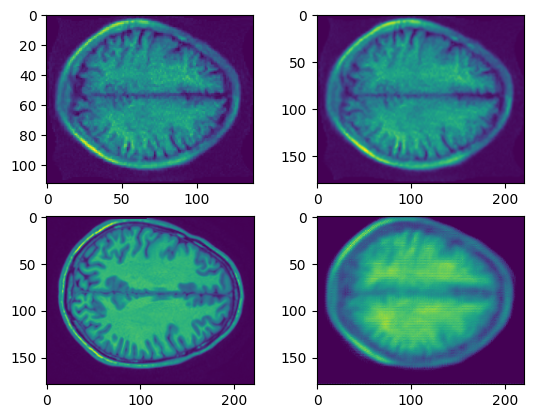

In [ ]:
z_ratio = 2

# Create Dataset
# dataset = create_3D_Image_DF()
dataset = pd.read_pickle(os.path.join(PATH, './data/misc/data3D.pkl'))

# Split (train / val) vs (test)
test_size = 2 # Can be test size or test ratio
train_val_set, test_set = train_test_split(dataset, test_size=test_size)

batch_size = 1
train_val_dataset = image_3D_dataset(train_val_set)
test_dataset = image_3D_dataset(test_set)
train_val_loader = DataLoader(train_val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Get Input and target image and their meta data
torch_dataset = image_3D_dataset(dataset)
torch_loader = DataLoader(torch_dataset)
inputs, targets = next(iter(torch_loader))
inputs_shape = list(inputs.shape)
targets_shape = list(targets.shape)
B_input, C_input, X_input, Y_input, Z_input = inputs_shape
B_target, C_input, X_target, Y_target, Z_target = targets_shape
print(f"DataLoader imgs shape:{inputs_shape}")
print(f"DataLoader target shape:{targets_shape}")

# Plotting image
fig, ax = plt.subplots(2, 2)
#   Input Image
ax[0, 0].imshow(inputs[0, 0][..., Z_input // z_ratio]) 
#   Target Image
ax[1, 0].imshow(targets[0, 0][..., Z_target // z_ratio])

if True:
    total_k_loss = 0
    k_split = 10 # Give validation size or validation ratio
    best_model = None
    best_loss = np.inf
    for k in range(k_split):
        print('=' * 5, f"Starting Fold: {k} ", '=' * 5)
        # Load Model
        # model = SRResNet()
        model = UNet3DUpsampler()
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)

        # Split (Train) vs (Val)
        train_set, val_set = train_test_split(dataset, test_size=k_split)
        train_set = image_3D_dataset(train_set)
        val_set = image_3D_dataset(val_set)
        train_set_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
        val_set_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
    
        # Loss function
        criterion = nn.MSELoss() 
        # criterion = nn.L1Loss()
        # criterion = kaggle_loss()
        # criterion = HybridLoss() 

        # Optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

        limit, counter = 3, 0
        for e in range(30):  # Epochs
            print(f"Epoch {e+1}, Fold {k}\n-------------------------------")
            train_loop(train_set_loader, device, model, criterion, optimizer, batch_size)
            val_loss = test_loop(val_set_loader, device, model, criterion)

            if val_loss < best_loss:
                best_loss = val_loss
                counter = 0
                torch.save(model.state_dict(), os.path.join(PATH, 'k_fold_model.pt'))
            else:
                counter += 1
                if counter > limit:
                    print(f'WARNING OVERFIT, Consecutive {counter}')
                    break
        break # Comment this out for full k-Fold validation

    print(f'Average Loss over K-{k_split}: {total_k_loss / k_split}')

    print(f'Final Test\n-------------------------------')
    val_loss = test_loop(test_loader, device, model, criterion)
    print(val_loss)

#   Model Image Output
inputs = inputs.to(device)
ouput = model.forward(inputs).detach().cpu()
print(f'output shape: {ouput.shape}\nsum: {ouput.sum()}')
# ax[1, 1].imshow(ouput[0, 0][..., Z_target // z_ratio])
ax[1, 1].imshow(ouput[0, 0, ..., Z_target // z_ratio])

#   Baseline Image
print(f"input: {inputs[0].shape}")
base_ouput = F.interpolate(
    inputs, 
    size=(X_target, Y_target, Z_target),
    mode='trilinear'
)[0, 0, :, :, Z_target // z_ratio].detach().cpu()
ax[0, 1].imshow(base_ouput)

plt.savefig(os.path.join(PATH, 'resnet_results.png'))
# plt.show()